<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epidemiologia/AFB_Proyecto/Epid_AFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [6]:
Q=2000
alpha=0.25
sigma=0.75
mu=1/26.5
tau=1e-4
c=.5
true_params = np.array((Q, alpha,sigma,mu,tau,c))
def AFB(y,t,ps):
    try:
        Q = ps['Q'].value
        alpha = ps['alpha'].value
        sigma = ps['sigma'].value
        mu = ps['mu'].value
        tau = ps['tau'].value
        c = ps['c'].value
    except:
        Q,alpha,sigma,mu,tau,c = ps
    L_s,L_i,B=y
    L_s_p=Q*(L_s+B)/(L_i+L_s+B)-L_s*(alpha-sigma*(B/(L_i+L_s+B)))-L_s*B*tau*(L_i/(L_i+L_s))
    L_i_p=L_s*B*tau*(L_i/(L_i+L_s))-c*L_i*(B/(L_i+L_s+B))
    B_p=L_s*(alpha-sigma*(B/(L_i+L_s+B)))-mu*B
    if(L_i==0):
        L_i_p=0
    return np.array([L_s_p,L_i_p,B_p])
L_s_fijo=(1/(2*alpha))*((Q/mu)*((-alpha+sigma+mu)+np.sqrt((alpha-sigma-mu)**2+4*alpha*mu)))
L_i_fijo=0
B_fijo=Q/mu

Definicion del modelo y aproximacion de la solucion.

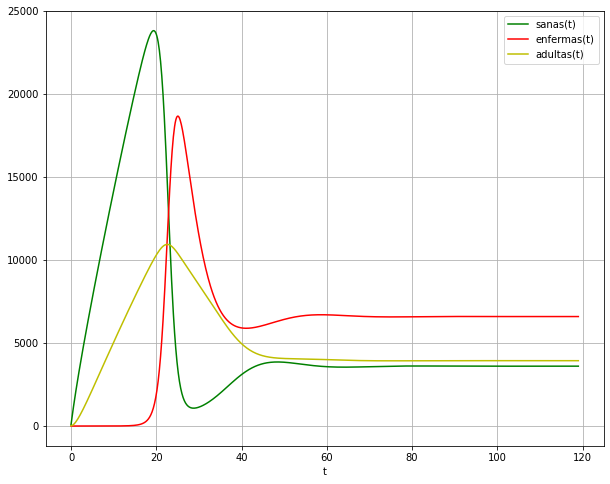

In [11]:
y0 = [100,1,20]
plt.figure(figsize=(10, 8))
INPUT = (y0[0],y0[1],y0[2])
t = np.linspace(0, 119, 119*7+1)
from scipy.integrate import odeint
sol = odeint(AFB, y0, t, args=([Q,alpha,sigma,mu,tau,c],))
plt.plot(t, sol[:, 0], 'g', label='sanas(t)')
plt.plot(t, sol[:, 1], 'r', label='enfermas(t)')
plt.plot(t, sol[:, 2], 'y', label='adultas(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [13]:
t

array([  0.        ,   0.14285714,   0.28571429,   0.42857143,
         0.57142857,   0.71428571,   0.85714286,   1.        ,
         1.14285714,   1.28571429,   1.42857143,   1.57142857,
         1.71428571,   1.85714286,   2.        ,   2.14285714,
         2.28571429,   2.42857143,   2.57142857,   2.71428571,
         2.85714286,   3.        ,   3.14285714,   3.28571429,
         3.42857143,   3.57142857,   3.71428571,   3.85714286,
         4.        ,   4.14285714,   4.28571429,   4.42857143,
         4.57142857,   4.71428571,   4.85714286,   5.        ,
         5.14285714,   5.28571429,   5.42857143,   5.57142857,
         5.71428571,   5.85714286,   6.        ,   6.14285714,
         6.28571429,   6.42857143,   6.57142857,   6.71428571,
         6.85714286,   7.        ,   7.14285714,   7.28571429,
         7.42857143,   7.57142857,   7.71428571,   7.85714286,
         8.        ,   8.14285714,   8.28571429,   8.42857143,
         8.57142857,   8.71428571,   8.85714286,   9.  

Generacion de datos sinteticos.

In [8]:
from scipy import stats

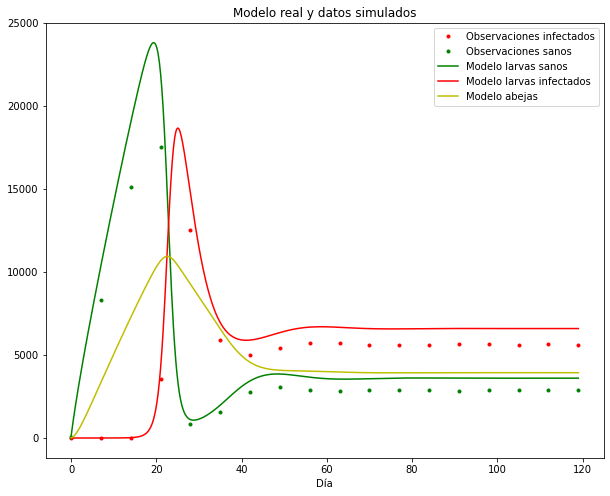

In [30]:
frecuancia_muestra=np.arange(0,len(t),7*7)
np.random.seed(0)
datos_larvas_infectados=np.array([stats.binom.rvs(n=int(sol[i,1]),p=0.85) for i in range(len(t))])[frecuancia_muestra]
datos_larvas_sanas=np.array([stats.binom.rvs(n=int(sol[i,0]),p=0.80) for i in range(len(t))])[frecuancia_muestra]
data=np.array([datos_larvas_sanas,datos_larvas_infectados]).T
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/7,datos_larvas_infectados,'r.',label='Observaciones infectados')
plt.plot(frecuancia_muestra/7,datos_larvas_sanas,'g.',label='Observaciones sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,2],'y',label='Modelo abejas')
plt.legend()
plt.xlabel('Día')
plt.title('Modelo real y datos simulados')
plt.show()

In [19]:
!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 6.7 MB/s 
     |████████████████████████████████| 98 kB 7.3 MB/s 


In [20]:
def modelo(t,INP,parametros):
    SOL = odeint(AFB,INPUT,t,args=(parametros,))
    return SOL

In [21]:
def residual(ps,ts,data):
    INP = ps['L_S_0'].value, ps['L_I_0'].value, ps['B'].value
    model = modelo(ts,INP,ps)
    return (model[frecuancia_muestra][:,0:2]-data).ravel()

In [23]:
from lmfit import minimize, Parameters, Parameter, report_fit
params = Parameters()
params.add('Q', value=1000, min=500, max=3000)
params.add('alpha', value=0.2, min=0, max=0.5)
params.add('sigma', value=0.55, min=0.5, max=1)#Se puede incluir la restriccion alpha<sigma?
params.add('mu', value=0.000001, min=0, max=0.5)
params.add('tau', value=0.000001, min=0, max=0.5)
params.add('c', value=0.5, min=0, max=1)
params.add('L_S_0', value=float(100), min=100, max=101)
params.add('L_I_0', value= float(1), min=1, max=2)
params.add('B', value=float(20), min=20, max=21)

In [24]:
result = minimize(residual, params, args=(t, data), method='leastsq',)

final = data + result.residual.reshape(data.shape)
result

In [25]:
print(true_params)

[2.00000000e+03 2.50000000e-01 7.50000000e-01 3.77358491e-02
 1.00000000e-04 5.00000000e-01]


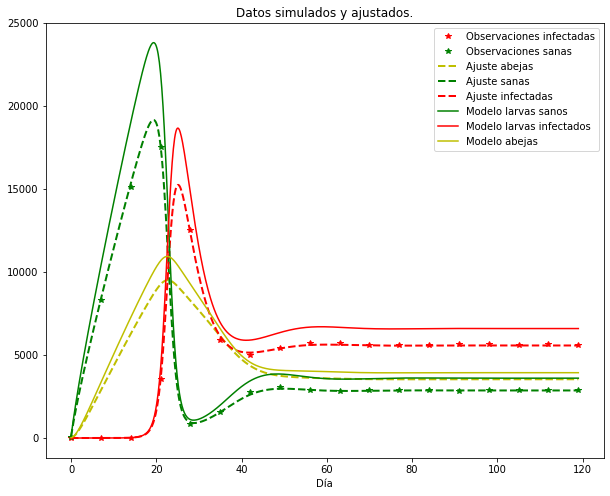

In [32]:
# plot data and fitted curves
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/7,data[:,1], '*r',label='Observaciones infectadas')
plt.plot(frecuancia_muestra/7,data[:,0], '*g',label='Observaciones sanas')

plt.plot(t,modelo(t,INPUT,result.params)[:,2], '--y', linewidth=2,label='Ajuste abejas');
plt.plot(t,modelo(t,INPUT,result.params)[:,0], '--g', linewidth=2,label='Ajuste sanas');
plt.plot(t,modelo(t,INPUT,result.params)[:,1], '--r', linewidth=2,label='Ajuste infectadas');
plt.plot(np.arange(0,119+1/7,1/7),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,2],'y',label='Modelo abejas')
plt.legend()
plt.xlabel('Día')
plt.title('Datos simulados y ajustados.')
plt.show()